In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import operator
import re
import calendar
from collections import Counter
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12,7
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [2]:
data = pd.read_pickle('master_VGC22')

In [91]:
data.head()

,Console,CriticScore,Date,Developer,Game,Id,JAP,NA,Other,PAL,Publisher,Total,UserScore,VGCScore,Day,Month,Year,WW
0,Wii,NAN,19th Nov 06,Nintendo EAD,Wii Sports,1,29.02,82.65,3.77,41.36,Nintendo,NAN,7.7,NAN,19,11,2006,156.80
1,NES,NAN,18th Oct 85,Nintendo EAD,Super Mario Bros.,2,3.58,40.24,6.81,29.08,Nintendo,NAN,10,NAN,18,10,1985,79.71
2,Wii,8.7,27th Apr 08,Nintendo EAD,Mario Kart Wii,3,12.92,35.9,3.8,15.84,Nintendo,9.1,8.2,NAN,27,4,2008,68.46
3,Wii,8.8,26th Jul 09,Nintendo EAD,Wii Sports Resort,4,10.98,32.9,3.29,15.61,Nintendo,8.8,8,NAN,26,7,2009,62.78
4,GB,NAN,30th Sep 98,Game Freak,Pok�mon Red / Green / Blue Version,5,8.89,31.37,10.22,11.27,Nintendo,NAN,9.4,NAN,30,9,1998,61.75


In [90]:
data['WW'] = [sum([float(i) for i in k]) for k in data[['JAP','NA','Other','PAL']].values]

In [4]:
def clean_date(date):
    try:
        dmy = re.split(' ',date)
        d = int(dmy[0][:-2])
        nametonum = {v: k for k,v in enumerate(calendar.month_abbr)}
        m = nametonum[dmy[1]]
        if dmy[2][0] == '0':
            y = int('20'+dmy[2])
        else:
            y = int('19'+dmy[2])
        return d,m,y
    except:
        return None,None,None
cdate = [clean_date(date) for date in list(data.Date)]
data['Day'],data['Month'],data['Year']=zip(*cdate)

In [5]:
iiigen = data[data.Year < 1993]
iiigen = iiigen[iiigen.Year > 1983]
cons = ['5200','7800', 'ACPC', 'AST', 'Aco', 'Amig', 'Arc', 'BBCM', 'BRW', 'C128', 'C64', 'MS', 'MSX', 'NES', 'PCE', 'TG16', 'ZXS']
iiigen = iiigen[iiigen.Console.isin(cons)]

devs_in_time = {}
for c in set(iiigen.Console):
    devs_in_time[c] = []    
    consdf = iiigen[iiigen.Console == c]
    mint = min(consdf.Year)
    maxt = max(consdf.Year)
    devs_in_time[c] = [len(set(consdf[consdf.Year == y].Developer)) for y in range(1983,1989)]

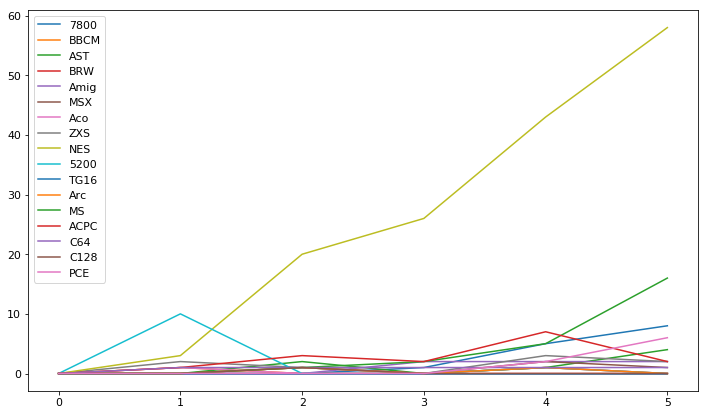

In [23]:
for i in devs_in_time.keys():
    plt.plot(devs_in_time[i],label=i)
plt.legend(loc=2)
plt.show()
    

In [105]:
#get total games released by developer for first 11 years (for all consoles)
totaldf = {}

datan = data[data.Year > 1972]

for c in set(datan.Console):
    nes = datan[datan.Console == c]
    
    #get rid of None years
    yrs = list(nes.Year)
    mint = min(yrs)
    if mint == None:
        mint = 0
    maxt = max(yrs)

    nesdev = pd.DataFrame.from_dict(Counter(nes.Publisher),orient='index')#,index=range(len(set(nes.Developer))))

    nesdev = nesdev.sort_values(by=0,ascending=False)

    nesdevn = {str(i):[] for i in nesdev.index}

    for n in nesdevn.keys():
        nesn = nes[nes.Publisher == n]
        tot = [len(set(nesn[nesn.Year == y].Game)) for y in range(mint,mint+11)]
        ww = [i for i in list(nesn.WW) if i > 0]
        totaldf[len(totaldf)] = [c]+[n]+tot+[sum(tot),sum(ww)]
tdf = pd.DataFrame.from_dict(totaldf,orient='index')
tdf.columns = ['Console','Publisher']+[str(i) for i in range(1,12)]+['Total','Units']
tdf = tdf.sort_values(by='Total',ascending=False)


In [106]:
home_console = [u'CD32', u'WW', u'WS', u'HTC', u'SAT', u'7800', u'Amig', u'GIZ', u'ZXS', u'GC', u'S32X', 
                u'BRW', u'Arc', u'OR', u'FDS', u'PS2', u'PS3', u'PS4', u'PCE', u'PS', u'SCD', u'TG16', u'GEN', u'2600',
                u'SNES', u'XOne', u'Odys', u'PVR', u'MS', u'NES', u'N64', u'AST', u'NG', u'NS', u'XB', u'C64', 
                u'CDi', u'WiiU', u'3DO', u'C128', u'ACPC', u'MSX', u'DC', u'MSD', u'PCFX', u'Ouya', u'X360', u'AJ',
                u'5200', u'Lynx', u'BBCM', u'Wii', u'Linux']

In [107]:
nes = tdf[tdf.Console.isin(home_console)]

In [108]:
nes.head()

,Console,Publisher,1,2,3,4,5,6,7,8,9,10,11,Total,Units
744,PS2,Konami,12,26,27,47,38,30,30,15,17,7,0,249,78.31
738,PS2,Sony Computer Entertainment,8,22,30,31,25,33,28,26,25,14,0,242,143.81
2527,GEN,Sega,0,0,3,18,22,35,32,40,43,29,8,230,32.49
4086,MS,Sega,4,26,31,43,23,20,20,16,26,4,1,214,0.00
255,DC,Sega,2,34,61,40,9,0,2,0,1,0,0,149,10.61


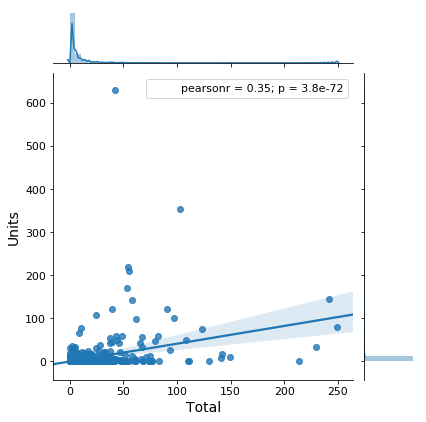

In [112]:
sns.jointplot('Total','Units',data=nes,kind="reg")

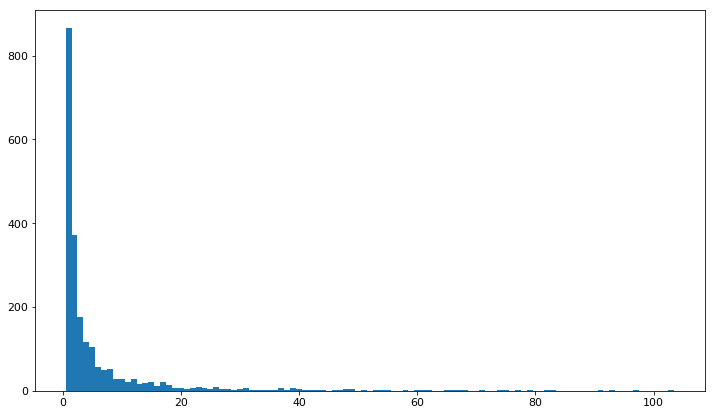

In [78]:
plt.bar(np.arange(1,104),[len(nes[nes.Total == i]) for i in np.arange(1,104)],width=1)
plt.show()

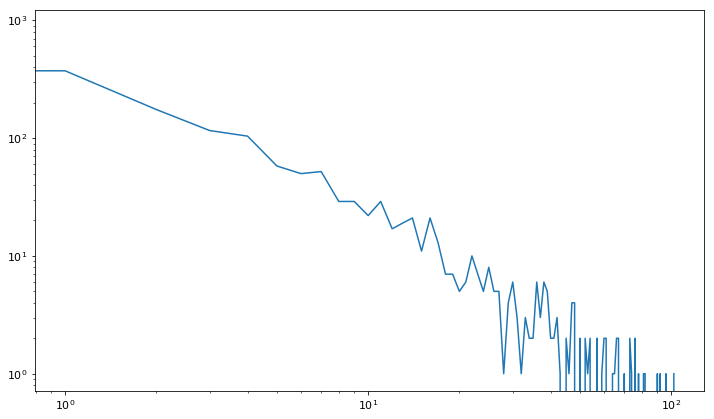

In [79]:
plt.plot([len(nes[nes.Total == i]) for i in np.arange(1,104)])
plt.loglog()
plt.show()

In [76]:
print len(nes[nes.Total > 20])
print len(nes[nes.Total.isin(range(5,20))])
print len(nes[nes.Total < 5])

157
482
1755


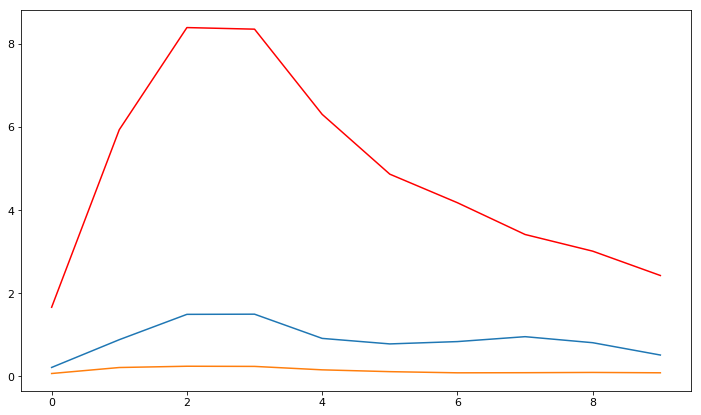

In [72]:
avg = []
for k in nes[nes.Total > 20].values:
    avg.append(k[2:12])

avgar = np.array(avg, dtype=np.float64)

avg = np.average(avgar, axis=0)
plt.plot(avg,label='> 20',c='r')

#stdev = np.std(avgar, axis=0)
#plt.plot(map(lambda x,y: x+y,avg,stdev),'--',label='> 20',c='r')
#plt.plot(map(lambda x,y: x-y,avg,stdev),'--',label='> 20',c='r')

avg = []
for k in nes[nes.Total.isin(range(5,20))].values:
    avg.append(k[2:12])
avgar = np.array(avg)
plt.plot(np.average(avgar, axis=0),label='20 - 5')

avg = []
for k in nes[nes.Total < 5].values:
    avg.append(k[2:12])
avgar = np.array(avg)
plt.plot(np.average(avgar, axis=0),label='< 5')


plt.show()

In [34]:
a = [[2,3],[4,5]]
[zip(i) for i in a]

[[(2,), (3,)], [(4,), (5,)]]

In [38]:
map([[1],[2]])

TypeError: map() requires at least two args